In [2]:

import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
from sklearn.preprocessing import StandardScaler
import nibabel as nib
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.calibration import calibration_curve
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 0) # this needs to be modified for some tasks
print('%i regions found in this atlas' % (len(np.unique(atlas_nii.get_data().ravel())) - 1))
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] # gives subject age on standard units after z-scoring

     |████████████████████████████████| 10.0 MB 5.1 MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)



Dataset created in /root/nilearn_data/oasis1



Downloaded 899006464 of 905208634 bytes (99.3%,    0.2s remaining) ...done. (33 seconds, 0 min)
Extracting data from /root/nilearn_data/oasis1/adcb228c7b26ed4f4fba93bd32bf8d97/archive_dartel.tgz..... done.
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)



Dataset created in /root/nilearn_data/craddock_2012



 ...done. (0 seconds, 0 min)
Extracting data from /root/nilearn_data/craddock_2012/45a4e574a5c116b8be81d080bdaa0814/craddock_2011_parcellations.tar.gz..... done.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


10 regions found in this atlas


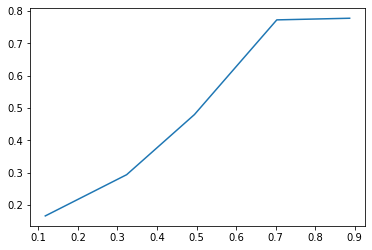

In [5]:
from sklearn.linear_model import LogisticRegression
##### median ##########
median = np.median(output_variable)
#########  let 0 represent young, 1 represent old ##########
trans_output_variable = []
# trans_y_pred = []
for i in range(len(output_variable)):
  if output_variable[i] >= median:
    trans_output_variable.append(1)
    # trans_y_pred.append(1)
  # elif output_variable[i] < median:
  #   trans_output_variable.append(0)
  #   trans_y_pred.append(0)
  # elif output_variable[i] >= median and y_pred[i] < median:
  #   trans_output_variable.append(1)
  #   trans_y_pred.append(0)
  else:
    trans_output_variable.append(0)
    # trans_y_pred.append(1)

# SGDmodel = SGDRegressor(penalty='l2',alpha=0.0001)
Logmodel = LogisticRegression(penalty='l2',C=1.0)
y_pred = cross_val_predict(Logmodel, input_variables, trans_output_variable, cv=10, method = 'predict_proba')

prob_true, prob_pred = calibration_curve(trans_output_variable, y_pred[:,1], n_bins=5)

plt.plot(prob_pred, prob_true)
plt.show()